In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# df = pd.read_fwf('SUEWS_SiteSelect_sorted.txt')
# df.columns=df.iloc[0]
# df=df.reindex(df.index.drop(0))
# df.drop(df.tail(2).index,inplace=True)
# df= df.astype(float)
# lat=df['lat']
# lon=df['lng']

In [3]:
df = pd.read_csv('SUEWS_SiteSelect_v2017_2m_wall_limit.txt',sep='\t')
df.columns=df.iloc[0]
df=df.reindex(df.index.drop(0))
df.drop(df.tail(2).index,inplace=True)
df= df.astype(float)
lat=df['lat']
lon=df['lng']

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# df = pd.read_csv('SUEWS_SiteSelect.txt',sep='\t')
# df.columns=df.iloc[0]
# df=df.drop(df.index[0])
# df.drop(df.tail(2).index,inplace=True)
# df= df.astype(float)
# lat=df['lat']
# lon=df['lng']

In [5]:
df.head()

,Grid,Year,StartDLS,EndDLS,lat,lng,Timezone,SurfaceArea,Alt,z,...,Fr_ESTMClass_Bldgs4,Fr_ESTMClass_Bldgs5,Code_ESTMClass_Bldgs1,Code_ESTMClass_Bldgs2,Code_ESTMClass_Bldgs3,Code_ESTMClass_Bldgs4,Code_ESTMClass_Bldgs5,!,Site,Reference
1,63707.0,2015.0,85.0,302.0,51.4278,0.051611,0.0,1.0,0.0,17.452543,...,1.0,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN
2,64064.0,2015.0,85.0,302.0,51.4278,0.050174,0.0,1.0,0.0,19.013241,...,1.0,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN
3,64065.0,2015.0,85.0,302.0,51.4287,0.051553,0.0,1.0,0.0,22.478087,...,1.0,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN
4,64422.0,2015.0,85.0,302.0,51.4277,0.048738,0.0,1.0,0.0,16.552772,...,1.0,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN
5,64423.0,2015.0,85.0,302.0,51.4287,0.050116,0.0,1.0,0.0,19.044050,...,1.0,0.0,801.0,803.0,8021.0,8022.0,8041.0,NaN,NaN,NaN


In [6]:
from pyproj import Proj, transform

# p2_text='''
# +units=m +init=ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=51.51 +lon_0=0.13 
# +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
# '''

p2_text='''
+units=m +init=ESRI:102009 +proj=lcc +lat_1=30 +lat_2=60 +lat_0=51.51 +lon_0=-0.96 
+x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +no_defs +towgs84=0,0,0
'''

p1 = Proj(init='epsg:32631')
p2 = Proj(p2_text)
x1, y1 = p1(list(lon),list(lat))
x2, y2 = transform(p1,p2,x1,y1)

In [7]:
x_file='wrfinput_d03.suews'
ds_base = xr.open_dataset(x_file)
wrf_LAT=ds_base.XLAT.values[0,:,:]
wrf_LON=ds_base.XLONG.values[0,:,:]


wrf_X,wrf_Y=p2(wrf_LON,wrf_LAT)

In [9]:
def pc_plot(grid_x, grid_y,new_Z,name):
    plt.figure(figsize=(10,10))
    plt.pcolor(grid_x, grid_y,new_Z)
    plt.colorbar()
    plt.title(name)
    plt.ylabel('y')
    plt.xlabel('x')
    

In [10]:
def regrid_lower(name):
    Z=df[name]
    grid_x=wrf_X
    grid_y=wrf_Y
    new_Z=griddata(list(zip(x2,y2)), Z.values, (grid_x, grid_y), method='linear')
    #pc_plot(grid_x, grid_y,new_Z,name)
    return grid_x, grid_y,new_Z

In [40]:
names=['H_Bldgs','H_EveTr','H_DecTr']
names_wrf=['bldgH_SUEWS','EveTreeH_SUEWS','DecTreeH_SUEWS']

for name,name_wrf in zip(names,names_wrf):
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    #new_all.update( {name : new_0} )
    ds_var=ds_base[name_wrf.upper()].values[0,:,:]
    ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]
    zz=ds_base[name_wrf.upper()].values[0,:,:]
    zz[zz<0]=0
    ds_base[name_wrf.upper()].values[0,:,:]=zz

H_Bldgs
H_EveTr
H_DecTr


In [10]:
pc_plot(grid_x, grid_y,zz,'new')

NameError: name 'grid_x' is not defined

PopDensNight
PopDensNight


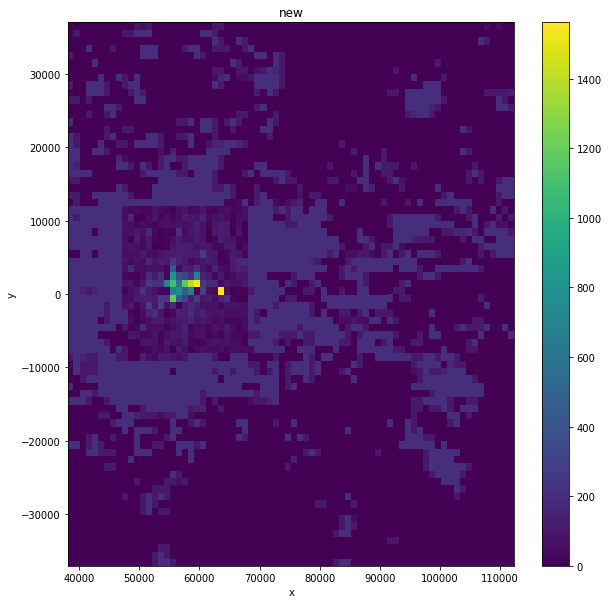

In [11]:
names=['PopDensNight','PopDensNight']
names_wrf=['PopDensNightTime_SUEWS','PopDensDayTime_SUEWS']

for name,name_wrf in zip(names,names_wrf):
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    #new_all.update( {name : new_0} )
    ds_var=ds_base[name_wrf.upper()].values[0,:,:]
    ds_var[~np.isnan(new_0)]=new_0[~np.isnan(new_0)]
    zz=ds_base[name_wrf.upper()].values[0,:,:]
    zz[zz<0]=0
    ds_base[name_wrf.upper()].values[0,:,:]=zz
pc_plot(wrf_X, wrf_Y,ds_base['PopDensNightTime_SUEWS'.upper()].values[0,:,:],'new')

In [43]:
names=['Fr_Paved' ,'Fr_Bldgs' ,'Fr_EveTr' ,'Fr_DecTr' ,'Fr_Grass' ,'Fr_Bsoil','Fr_Water']
new_all={}
for name in names:
    print(name)
    grid_x, grid_y,new_0=regrid_lower(name)
    new_all[name]=new_0

Fr_Paved
Fr_Bldgs
Fr_EveTr
Fr_DecTr
Fr_Grass
Fr_Bsoil
Fr_Water


In [44]:
new_0=new_all['Fr_Paved']
cd=~np.isnan(new_0)
ds_base['LANDUSEF'].values[0,12,:,:][cd]=new_all['Fr_Paved'][cd]+new_all['Fr_Bldgs'][cd]

ds_base['LANDUSEF'].values[0,0,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,1,:,:][cd]=new_all['Fr_EveTr'][cd]/3
ds_base['LANDUSEF'].values[0,4,:,:][cd]=new_all['Fr_EveTr'][cd]/3

ds_base['LANDUSEF'].values[0,2,:,:][cd]=new_all['Fr_DecTr'][cd]/2
ds_base['LANDUSEF'].values[0,3,:,:][cd]=new_all['Fr_DecTr'][cd]/2

ds_base['LANDUSEF'].values[0,5,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,6,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,7,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,8,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,9,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,11,:,:][cd]=new_all['Fr_Grass'][cd]/7
ds_base['LANDUSEF'].values[0,13,:,:][cd]=new_all['Fr_Grass'][cd]/7

ds_base['LANDUSEF'].values[0,15,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,17,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,18,:,:][cd]=new_all['Fr_Bsoil'][cd]/4
ds_base['LANDUSEF'].values[0,19,:,:][cd]=new_all['Fr_Bsoil'][cd]/4


ds_base['LANDUSEF'].values[0,10,:,:][cd]=new_all['Fr_Water'][cd]/2
ds_base['LANDUSEF'].values[0,16,:,:][cd]=new_all['Fr_Water'][cd]/2

In [ ]:
pc_plot(wrf_X, wrf_Y,ds_base['LANDUSEF'].values[0,12,:,:],'new')

In [15]:
ds_merged = ds_base.update(ds_base)    

for var in ds_merged.data_vars.keys():
    if 'coordinates' in ds_merged[var].attrs:
        del ds_merged[var].attrs['coordinates']
        
file_out = x_file+'.new'

ds_merged.to_netcdf(file_out,
                    mode='w', format='NETCDF3_64BIT')
print('SUEWS input has beened added to:' + file_out)

SUEWS input has beened added to:wrfinput_d03.suews.new
